# Analysis of the flagman model

In [41]:
from sklearn.model_selection import train_test_split

from movie_lens_lib import *
from visualization import *

### Constants

In [2]:
n_movie_clusters = 5
rating_multiplier = 5
year_multiplier = 0.05
weight_genre, weight_cluster, weight_movie = 0.35, 0.45, 0.2
train_size = 0.9
random_state = 42

### Import & Split dataset

In [3]:
ratings_df = pd.read_csv("data/ratings.csv")
movies_df = pd.read_csv("data/movies.csv", index_col="movieId")

X = ratings_df.drop(["rating"], axis=1)
y = ratings_df["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
ratings_train_df = pd.concat([X_train, y_train], axis=1)
ratings_test_df = pd.concat([X_test, y_test], axis=1)

### Preprocess

In [4]:
movies_hot_df = PreProcessingAggregated().transform((movies_df, ratings_train_df))

In the cell below we calculate the number of occurrences of a user in the training set.

In [5]:
ratings_test_grouped = ratings_train_df.copy()
ratings_test_grouped["rating_count"] = np.ones(ratings_test_grouped.shape[0])
ratings_test_grouped = ratings_test_grouped.groupby("userId")["rating_count"].sum().to_frame()
ratings_test_df = ratings_test_df.merge(ratings_test_grouped, on="userId")
ratings_test_df.head()

,userId,movieId,timestamp,rating,rating_count
0,23474,8636,1623093417,2.0,158.0
1,23474,593,1622908173,4.5,158.0
2,23474,4963,1622907887,3.5,158.0
3,23474,81845,1622908031,4.0,158.0
4,23474,84152,1622991895,3.5,158.0


## Performance vs Number of records in the training set
Fit the regressor.

In [6]:
hybrid_regressor = HybridRegressor(
    movies_hot_df,
    cluster_based_regressor = ClusterBasedRegressor(
        movies_hot_df,
        n_movie_clusters,
        rating_multiplier,
        year_multiplier,
        random_state),
    weights=(weight_genre, weight_cluster, weight_movie)
).fit(X_train, y_train)

Function for gauging the experiment results for the purpose of creating a visualization.

In [7]:
def hybrid_step(results, threshold, upper_bound=None):
    x_test_sample = None
    if upper_bound:
        x_test_sample = ratings_test_df[
            (ratings_test_df["rating_count"] >= threshold) &
            (ratings_test_df["rating_count"] < upper_bound)
        ]
    else:
        x_test_sample = ratings_test_df[
            (ratings_test_df["rating_count"] >= threshold)
        ]
        
    y_true = x_test_sample["rating"].values
    hybrid_predictions = hybrid_regressor.predict(x_test_sample, False)
    hybrid_results = get_performance_stats(y_true, hybrid_predictions)
    results[threshold] = hybrid_results

Conduct the experiment.

In [8]:
results = {}
thresholds = [0, 5, 10, 20, 50, 100, 200]

for i in range(1, len(thresholds)):
    hybrid_step(results, thresholds[i-1], thresholds[i])
hybrid_step(results, thresholds[-1])

Visualize the results.

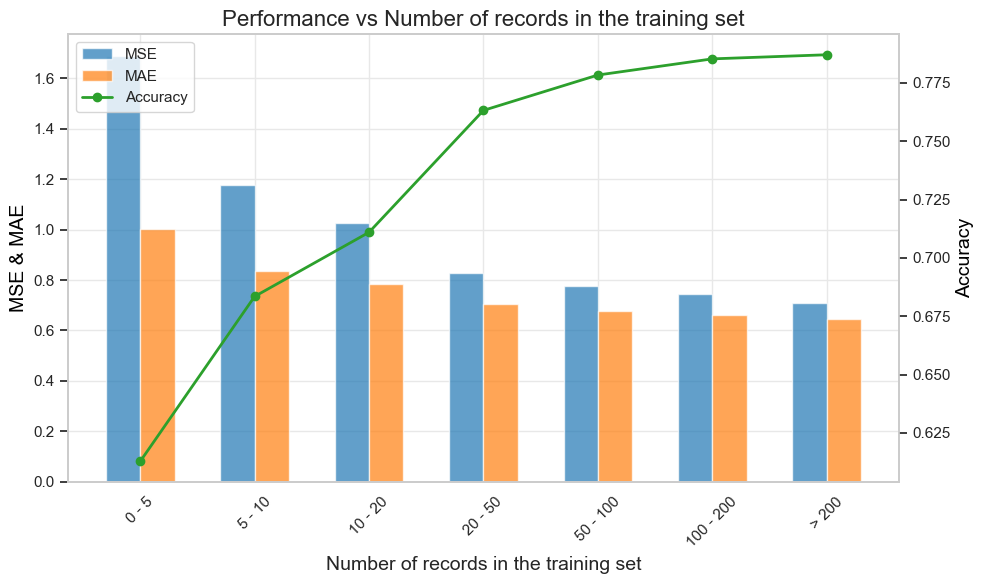

In [42]:
hybrid_metrics_by_user_records(results, thresholds)

There is an obvious tendency that users who have more ratings in the training set get better performance of prediction when encountered in the testing set. The plot above shows the relation between the number of ratings upon which the model was trained (for each user) and the predictive performance of the model. E.g. for the column 10-20, we tested performance of our hybrid model only on the users who had between 10 and 20 records in the training dataset.

## Performance of Hybrid method based on the number of clusters

In [10]:
hybrid_results = {}

for n in range(2, 11):
    hybrid_regressor = HybridRegressor(
        movies_hot_df,
        cluster_based_regressor = ClusterBasedRegressor(
            movies_hot_df,
            n,
            rating_multiplier,
            year_multiplier,
            random_state
        )
    ).fit(X_train, y_train)
    hybrid_predictions = hybrid_regressor.predict(X_test, False)
    hybrid_results[n] = get_performance_stats(y_test, hybrid_predictions)

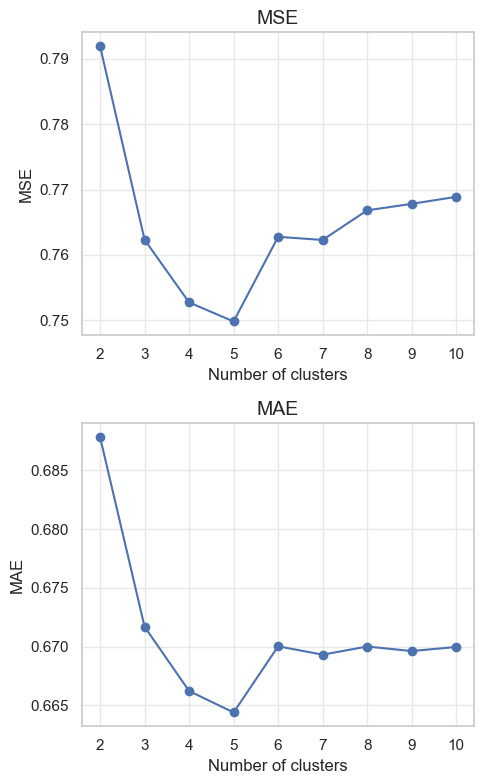

In [43]:
hybrid_metrics_by_cluster_size(hybrid_results)

The best number of clusters seems to be 5.